<a href="https://colab.research.google.com/github/adalves-ufabc/2022.Q2-PLN/blob/main/2022_Q2_PLN_Notebook_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Processamento de Linguagem Natural [2022.Q2]**
Prof. Alexandre Donizeti Alves

# **Classificação de Textos**

Classificação de Textos é um processo automático de classificação em categorias pré-definidas. Há varias aplicações, tais como:

- Classificação de e-mails em spam ou não-spam;
- Classificação de notícias em diferentes categorias, tais como política, economia, esportes etc;
- Identificação de características do autor, como identidade, idade, preferência política etc;
- Detecção do idioma;
- Análise de sentimento em textos. 

Em geral, há duas etapas principais nesse processo:

1. Os documentos são imersos em um espaço vetorial, como discutido anteriormente.
1. Um algoritmo de [aprendizado de máquina](https://pt.wikipedia.org/wiki/Aprendizado_de_m%C3%A1quina) é usado para construir um modelo de classificação.

Para construir o modelo, geralmente usa-se o paradigma de aprendizado supervisionado, em que um conjunto de treinamento é composoto por documentos associado a seus rótulos. Uma vez treinado o modelo, ele pode ser usado para classificar automaticamente documentos cuja categoria não é conhecida.

### **Carregando a base de dados**

Nesse exemplo, usaremos uma base de dados composta por *reviews* de produtos da **Amazon**. Esse corpus contém 10.000 *reviews*, previamente classificados nas classes *`positive`* e *`negative`*. Cada *review* está armazenado em uma linha, e é composto por 2 colunas:

- *`text`* essa coluna contém o texto do *reviews*;
- *`label`* essa coluna contém a classe, determinada por um especialista, se o texto é um comentário `positivo` ou `negativo` a respeito de um produto.

Vamos usar o pacote pandas para ler esse corpus:

In [1]:
# carrega a biblioteca pandas, para fazer a leitura do corpus (base de dados)
import pandas as pd

# carrega o corpus
corpus = pd.read_csv("/content/corpus.csv",encoding='latin-1')

In [2]:
# mostra as primeiras 5 linhas do corpus
corpus.head()

,text,label
0,Stuning even for the non-gamer: This sound tr...,positive
1,The best soundtrack ever to anything.: I'm re...,positive
2,Amazing!: This soundtrack is my favorite musi...,positive
3,Excellent Soundtrack: I truly like this sound...,positive
4,"Remember, Pull Your Jaw Off The Floor After H...",positive


In [3]:
# mostra as utlimas 5 linhas do corpus
corpus.tail()

,text,label
9995,A revelation of life in small town America in...,positive
9996,Great biography of a very interesting journal...,positive
9997,Interesting Subject; Poor Presentation: You'd...,negative
9998,Don't buy: The box looked used and it is obvi...,negative
9999,Beautiful Pen and Fast Delivery.: The pen was...,positive


Antes de iniciar a classificação dos documentos, vamos fazer algumas análises da base. Vamos usar a biblioteca `seaborn` para fazer alguns gráficos. 

>
Inicialmente, vamos fazer uma contagem de documentos em cada classe:

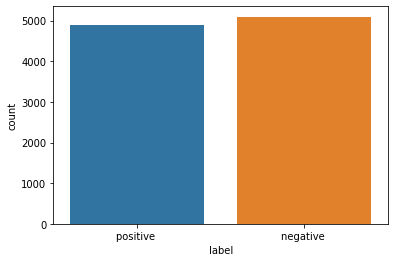

In [4]:
# biblioteca para fazer graficos
import seaborn as sns

# contagem de textos em cada classe
sns.countplot(x="label",data=corpus);

Vamos adicionar uma coluna à tabela que calcula o tamanho de cada documento, e comparar a distribuição de tamanho desses documentos usando um histograma. 

In [5]:
corpus['len'] = corpus['text'].str.len()

corpus['len'][:5]


0    428
1    510
2    761
3    744
4    482
Name: len, dtype: int64

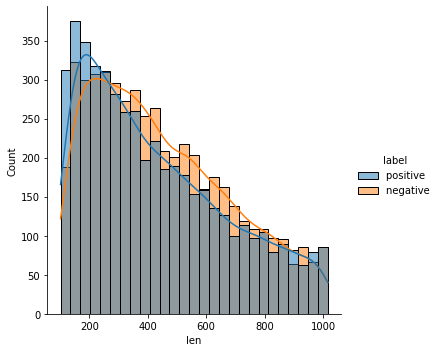

In [6]:
sns.color_palette("Set2")
sns.displot(data=corpus, x="len", hue="label", kind="hist", kde=True);

Como pode ser visualizado no gráfico, as distribuições são parecidas, apesar de haver uma maior quantidade de textos positivos curtos.

### **Pré-processamento**

O **pré-processamento** é uma importante para preparar os documentos para a geração dos vetores termo-documento. Vamos aplicar duas técnicas vistas no curso para fazer o processamento:

- Limpeza: usar as técnicas de expressões regulares para remover acentos, converter para minúsculos etc.
- Tokenização: usar um tokenizador para quebrar o documento em uma série de tokens.
- Stemming/Lemmatização: diferentes técnicas para transformar as palavra, reduzindo as inflexões a uma base comum.

Vamos usar o tokenizador, *stemmer* e lematizador da biblioteca [NLTK](https://www.nltk.org/).  Essa é uma biblioteca essencial que suporta diferentes tarefas como *stemming*, *tagging*, *parsing*, raciocínio semântico e tokenização. É uma das principais bibliotecas para processamento de linguagem natural.

In [12]:
import nltk

nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Vamos criar uma função que faz o pré-processamento. Essa função realiza os seguintes passos:

1. Quebra um texto em tokens
1. Converte os tokens para minúsculo
1. Remove as stopwords definidas no pacote `NLTK`
1. Remove a pontuação definida no pacote `strings`
1. aplica ou o *stemmer* (Porter) ou o lematizador (baseado na base wordnet)

In [8]:
# tokenizador
# ao inves de criar uma expressão regular explicita, vamos usar o wordpunct_tokenize
# ele define uma expressão regular para quebrar strings em substrings, repeitando a pontuacao
# a biblioteca NLTK disponibliza outros tokenizadores

from nltk.tokenize import wordpunct_tokenize

# lista de stopwords 
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# stemmer
from nltk.stem.porter import PorterStemmer
stm = PorterStemmer()

# lematizador
from nltk.stem.wordnet import WordNetLemmatizer
wnl = WordNetLemmatizer()

# pontuacao
import string

def preproc_tokenizer(text, reduc='stemmer'):
    
    # quebra o documento em  tokens
    words = wordpunct_tokenize(text) 
    
    # converte palavras para minusculo
    words = [word.lower() for word in words]
    
    # remove as stopwords
    words = [word for word in words if word not in stopwords]
    
    # remove pontuacao
    words = [word for word in words if word not in string.punctuation]
    
    if reduc == 'lemmatizer':
        words = [wnl.lemmatize(word) for word in words] 
    else:
        words = [stm.stem(word) for word in words]

    return(words)

Vamos agora usar essa função para acrescenter duas colunas à nossa base dados. Essas colunas contém, para cada documento, a lista de tokens preprocessada, com os tokens reduzidos ao radical com *stemmer* ou lematizador, respectivamente.

In [9]:
corpus['stems'] = [preproc_tokenizer(text,reduc='stemmer') for text in corpus['text']]

In [10]:
corpus['stems'][:5]

0    [stune, even, non, gamer, sound, track, beauti...
1    [best, soundtrack, ever, anyth, .:, read, lot,...
2    [amaz, !:, soundtrack, favorit, music, time, h...
3    [excel, soundtrack, truli, like, soundtrack, e...
4    [rememb, pull, jaw, floor, hear, play, game, k...
Name: stems, dtype: object

In [13]:
corpus['lemmas'] = [preproc_tokenizer(text,reduc='lemmatizer') for text in corpus['text']]

In [14]:
corpus['lemmas'].head()

0    [stuning, even, non, gamer, sound, track, beau...
1    [best, soundtrack, ever, anything, .:, reading...
2    [amazing, !:, soundtrack, favorite, music, tim...
3    [excellent, soundtrack, truly, like, soundtrac...
4    [remember, pull, jaw, floor, hearing, played, ...
Name: lemmas, dtype: object

Vamos fazer uma análise qualitativa, criando algumas nuvens de palavras dos *lemmas* e *stems* gerados.

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

def gen_wordcloud(texts, title, size=50):
    # conta a frequencia de cada termo 
    frequencies = Counter(token for doc in corpus['stems'] for token in set(doc))
    
    # gera a nuvem de palavras
    wc = WordCloud()
    wc.generate_from_frequencies(dict(frequencies.most_common(size)))
    
    # plota a nuvem
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.title(title)
    plt.axis("off")
    plt.show()

A nuvem de palavras pode então ser gerada a partir dos *stems*:

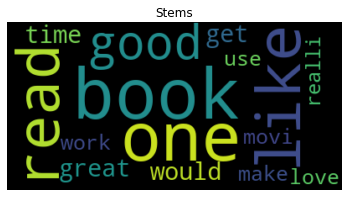

In [16]:
gen_wordcloud(corpus['stems'],"Stems", 15)

Podem gerar também a partir dos *lemmas*:

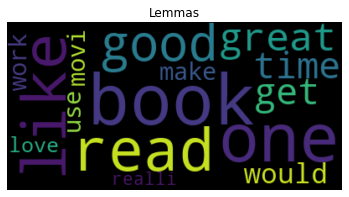

In [17]:
gen_wordcloud(corpus['lemmas'],"Lemmas", 15)

Podemos também gerar nuvens de palavras separadas por classe:

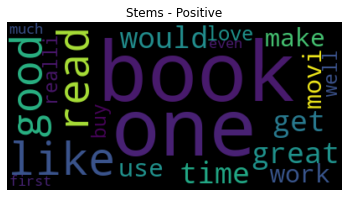

In [18]:
gen_wordcloud(corpus['stems'][corpus['label'].str.match('positive')],"Stems - Positive", 20)

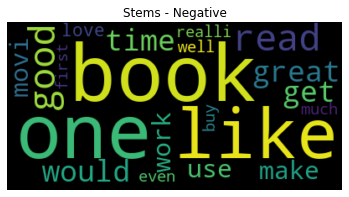

In [19]:
gen_wordcloud(corpus['stems'][corpus['label'].str.match('negative')],"Stems - Negative", 20)

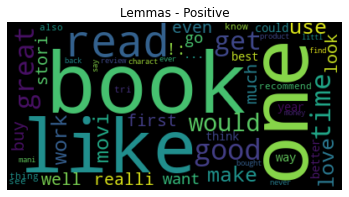

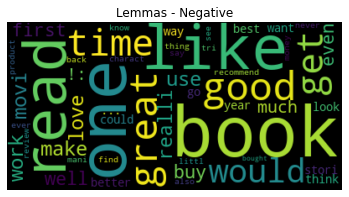

In [20]:
gen_wordcloud(corpus['lemmas'][corpus['label'].str.match('positive')],"Lemmas - Positive")
gen_wordcloud(corpus['lemmas'][corpus['label'].str.match('negative')],"Lemmas - Negative")

Para a criação dos modelos de classificação, vamos usar a biblioteca `scikit-learn`, que implementa diversos algoritmos de aprendizado de máquina. A [scikit-learn](https://scikit-learn.org/stable/index.html) é uma biblioteca de código aberto para a linguagem de programação Python. Ela inclui vários algoritmos de classificação, regressão e agrupamento, e é projetada para interagir com as bibliotecas Python numéricas e científicas (NumPy e SciPy).

### **Avaliação do Modelo de Classificação**

Um aspecto importante para análise de  modelos de classificação é que estamos interessados no desempenho futuro do modelo, quando ele for aplicado a novos textos cuja classe é desconhecida. Observe que, para um computador, seria fácil ter uma taxa de acerto de 100% em um conjunto fechado. Para isso, precisaríamos apenas construir uma tabela de consulta, armazenar esse conjunto, e retornar a classe associada aquele documento. Dessa maneira, precisamos avaliar o modelo em documentos diferentes daqueles usados para treinamento.


Isso implicaria, no entanto, encontrar novos textos e alguém que possa classificá-los corretamente, para comparar o resultado com a classificação automática feita pelo modelo. Uma alternativa é dividir a base dados em duas partes. Uma delas é usada apenas para **treinar** o modelo. E a outra parte é usada para **avaliar** o modelo. Dessa maneira, simulamos o processo de adquirir novos documentos.

Nesse experimento, vamos criar uma única partição, em que usaremos 70% dos documentos para treino e 30% para teste. Existem outras possibilidades para fazer essa partição, como a [validação cruzada](https://pt.wikipedia.org/wiki/Valida%C3%A7%C3%A3o_cruzada), em que várias partições de treino e teste são geradas.

In [21]:
# metodo que faz a divisao do conjunto de dados em treino e teste
from sklearn.model_selection import train_test_split

# separa o corpus original em dois corpus (treino e teste), deixando 30% no de teste
# como eh um processso aleatorio, fixei a semente para que o experimento seja reprodutivel
train_corpus, test_corpus =  train_test_split(corpus, test_size=0.3, random_state=0)

## Criação dos vetores termo-documento

Os algoritmos de aprendizado de máquina, em geral, usam como entrada vetores numéricos, e não textos. Entretanto, como visto anteriormente, podemos criar espaços vetoriais de imersão para representar documentos. Em nossos experimentos, vamos usar a representação **`TF-IDF`** para representar os documentos. 

O `scikit-learn` tem implementado uma classe que aplica a representação **`TF-IDF`**, chamada `TfidfVectorizer`. Um detalhe importante para usar essa classe é que, como os documentos de treino e teste podem ser diferentes (podem haver palavras nos documentos do conjunto de teste que não estão no conjunto de teste) devemos usar o mesmo vocabulário do conjunto de treinamento. Na interface do `scikit-learn`, isso pode ser feito usando a função `fit_transform` no conjunto de treinamento, e a função `transform` no conjunto de teste. 

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

train_stems = vectorizer.fit_transform([" ".join(doc) for doc in train_corpus['stems']])
test_stems = vectorizer.transform([" ".join(doc) for doc in test_corpus['stems']])

train_lemmas = vectorizer.fit_transform([" ".join(doc) for doc in train_corpus['lemmas']])
test_lemmas = vectorizer.transform([" ".join(doc) for doc in test_corpus['lemmas']])

Uma vez criada a matriz termo-documento, podemos criar os modelos de classificação. Nesse experimento, vamos comparar três algoritmos diferentes:

- [SVM](https://pt.wikipedia.org/wiki/M%C3%A1quina_de_vetores_de_suporte) As máquinas de vetores de suporte (SVM, do inglês: *Support Vector Machine*) contempla uma família de algoritmos de aprendizado de máquina que busca encontrar uma hiperplano que separa as classes no espaço vetorial de maneira a a maximizar a distância entre os pontos mais próximos em relação a cada uma das classes.

- [Regressão Logística](https://pt.wikipedia.org/wiki/Regress%C3%A3o_log%C3%ADstica) A regressão logística é um modelo que tenta atribuir probabilidades a diferentes categorias. Ela assume que as classes podem ser modeladas como uma distribuição multivariada, e usa a distância ao centro da distribuição de cada uma das classes para calcular a verossimilhança entre as classes. Para transformar em probabilidades, essa verossimilhante é transformada em probabilidades usando a função logística.

- [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) O Naive Bayes é baseado no teorema de Bayes para classificar os documentos. O teorema é usado para calcular a probalidade da classe, dado o valor dos atributos, a partir da probabilidade de cada atributo, dada a classe. O algoritmo é chamado *naive* (ingênuo), pois não considera a probabilidade conjunta entre as classes. 

Para comparar os algoritmos, vamos usar porcentagem de acertos (**acurácia**). Essa métrica compara a predição para o conjunto de teste com o valor real da classe e calcula a porcentagem de acertos. Como a base é balanceada, essa métrica é um bom indicador da qualidade do modelo, mas se tivermos uma desproporção entre as classes, outras métricas podem ser usadas.

In [36]:
# carrega os algoritmos
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# métrica de avaliação
from sklearn.metrics import accuracy_score

# cria objetos para aplicar os algoritmos. 
# Usamos um dicionário com o nome, objeto para facilitar a visualização dos resultados
algoritms = {'SVM' : LinearSVC(),'Regressão Logística' : LogisticRegression(), 'Naive Bayes': GaussianNB()}

In [38]:
# executa os algoritmos para a base pre-processada com o stemmer
for name, alg in algoritms.items():
    alg.fit(train_stems.toarray(),train_corpus['label'])
    predictions = alg.predict(test_stems.toarray())
    print("Acurácia média com stemming e o algoritmo {0} {1:.2f}%".format(name, accuracy_score(test_corpus['label'],predictions)*100))

Acurácia média com stemming e o algoritmo SVM 85.27%
Acurácia média com stemming e o algoritmo Regressão Logística 86.33%
Acurácia média com stemming e o algoritmo Naive Bayes 62.33%


In [39]:
# executa os algoritmos para a base pre-processada com o lemmatizador
for name, alg in algoritms.items():
    alg.fit(train_lemmas.toarray(),train_corpus['label'])
    predictions = alg.predict(test_lemmas.toarray())
    print("Acurácia média com lematização e o algoritmo {0} {1:.2f}%".format(name, accuracy_score(test_corpus['label'],predictions)*100))

Acurácia média com lematização e o algoritmo SVM 86.27%
Acurácia média com lematização e o algoritmo Regressão Logística 86.77%
Acurácia média com lematização e o algoritmo Naive Bayes 65.77%


Como pode ser visto nos resultados, para essa base, o uso de lematização produziu resultados superiores (em termos de acurácia) para todos os algoritmos. Entretanto, esse resultado depende da partição (se você trocar o *`random_state`* na divisão do conjunto de dados em treino/teste, o resultado pode variar). O uso de validação-cruzada pode diminuir a influência da aleatoriedade da partição (pois a comparação é feita com base na média de várias partições).

**Referência**:

Este notebook foi criado pelo prof. **Ronaldo Prati** [UFABC], tendo sido apenas reestruturado por mim.
